In [1]:
# For processing the data
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline
sns.set_style("white") # set style for seaborn plots

import matplotlib as mpl
from pylab import savefig
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import  Lasso # линейная модель с L1-регуляризацией
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('kobe.csv')

In [3]:
data.head()

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
0    167     72 -118.1028                 10       1  ...  2PT Field Goal   
1   -157      0 -118.4268                 10       1  ...  2PT Field Goal   
2   -101    135 -118.3708                  7       1  ...  2PT Field Goal   
3    138    175 -118.1318                  6       1  ...  2PT Field Goal   
4      0      0 -118.2698                  6       2  ...  2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \
0          Right Side(R)        Mid-Range        16-24 ft.  1610612747   
1           Left Side(L)        Mid-Range         8-16 ft.  1610612747   
2   Left Side Center(LC)        Mid-Range        16-24 ft.  1610612747   
3  Right Side Center(RC)        Mid-Range        16-24 ft.  1610612747   
4              Center(C)  Restricted Area  Less Than 8 ft.  1610612747   

            team_name   game_date    matchup opponent  shot_id  
0  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        1  
1  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        2  
2  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        3  
3  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        4  
4  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        5  

[5 rows x 25 columns]

In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

1. Анализ данных

In [5]:
data.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

In [6]:
data["period"] = data["period"].astype('object')

vars_to_category = ["combined_shot_type", "game_event_id", "game_id", "playoffs", 
                    "season", "shot_made_flag", "shot_type", "team_id"]
for col in vars_to_category:
    data[col] = data[col].astype('category')

# Let us check the final types
data.dtypes

action_type             object
combined_shot_type    category
game_event_id         category
game_id               category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
team_id               category
team_name               object
game_date               object
matchup                 object
opponent                object
shot_id                  int64
dtype: object

In [7]:
print("Dimensions of out DataFrame:", data.shape)

Dimensions of out DataFrame: (30697, 25)


In [8]:
data.info

<bound method DataFrame.info of              action_type combined_shot_type game_event_id   game_id      lat  \
0              Jump Shot          Jump Shot            10  20000012  33.9723   
1              Jump Shot          Jump Shot            12  20000012  34.0443   
2              Jump Shot          Jump Shot            35  20000012  33.9093   
3              Jump Shot          Jump Shot            43  20000012  33.8693   
4      Driving Dunk Shot               Dunk           155  20000012  34.0443   
...                  ...                ...           ...       ...      ...   
30692          Jump Shot          Jump Shot           397  49900088  33.9963   
30693           Tip Shot           Tip Shot           398  49900088  34.0443   
30694  Running Jump Shot          Jump Shot           426  49900088  33.8783   
30695          Jump Shot          Jump Shot           448  49900088  33.7773   
30696          Jump Shot          Jump Shot           471  49900088  33.9723   

       

In [9]:
data.describe(include=['number'])

lat         loc_x         loc_y           lon  \
count  30697.000000  30697.000000  30697.000000  30697.000000   
mean      33.953192      7.110499     91.107535   -118.262690   
std        0.087791    110.124578     87.791361      0.110125   
min       33.253300   -250.000000    -44.000000   -118.519800   
25%       33.884300    -68.000000      4.000000   -118.337800   
50%       33.970300      0.000000     74.000000   -118.269800   
75%       34.040300     95.000000    160.000000   -118.174800   
max       34.088300    248.000000    791.000000   -118.021800   

       minutes_remaining  seconds_remaining  shot_distance       shot_id  
count       30697.000000       30697.000000   30697.000000  30697.000000  
mean            4.885624          28.365085      13.437437  15349.000000  
std             3.449897          17.478949       9.374189   8861.604943  
min             0.000000           0.000000       0.000000      1.000000  
25%             2.000000          13.000000       5.000000   7675.000000  
50%             5.000000          28.000000      15.000000  15349.000000  
75%             8.000000          43.000000      21.000000  23023.000000  
max            11.000000          59.000000      79.000000  30697.000000

In [10]:
data.describe(include=['object', 'category'])

action_type combined_shot_type  game_event_id   game_id  period  \
count        30697              30697          30697     30697   30697   
unique          57                  6            620      1559       7   
top      Jump Shot          Jump Shot              2  21501228       3   
freq         18880              23485            132        50    8296   

        playoffs   season  shot_made_flag       shot_type shot_zone_area  \
count      30697    30697         25697.0           30697          30697   
unique         2       20             2.0               2              6   
top            0  2005-06             0.0  2PT Field Goal      Center(C)   
freq       26198     2318         14232.0           24271          13455   

       shot_zone_basic  shot_zone_range     team_id           team_name  \
count            30697            30697       30697               30697   
unique               7                5           1                   1   
top          Mid-Range  Less Than 8 ft.  1610612747  Los Angeles Lakers   
freq             12625             9398       30697               30697   

         game_date    matchup opponent  
count        30697      30697    30697  
unique        1559         74       33  
top     2016-04-13  LAL @ SAS      SAS  
freq            50       1020     1978

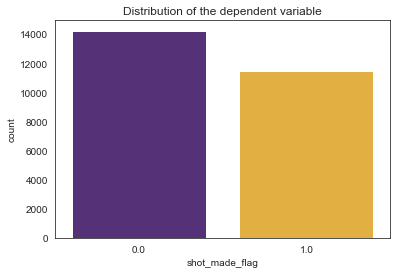

In [11]:
ax = plt.axes()
sns.countplot("shot_made_flag", data=data, ax=ax, palette=("#552583", "#FDB927"))
ax.set_title("Distribution of the dependent variable")
plt.show()

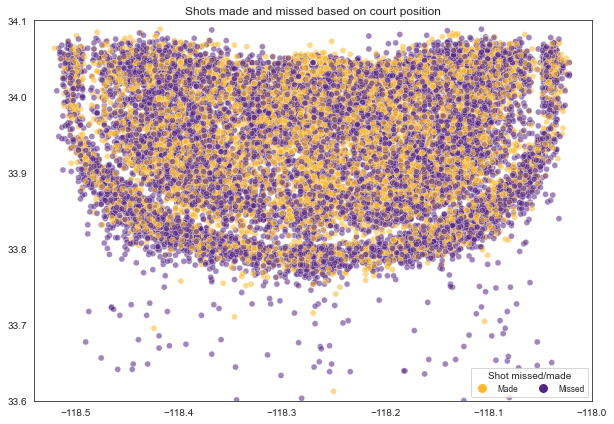

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = sns.scatterplot(x=data["lon"], y=data["lat"], hue=data['shot_made_flag'],
                                    alpha=0.55, ax=ax, palette=("#552583", "#FDB927"))
scatter.set_xlim(left=-118.54, right=-118)
scatter.set_ylim(bottom=33.6, top=34.1)
ax.set_title("Shots made and missed based on court position")
ax.set_xlabel("")
ax.set_ylabel("")
legend_elemnts = [Line2D([0], [0], marker="o", color='w', label="Made",
                         markerfacecolor="#FDB927", markersize=10),
                  Line2D([0], [0], marker="o", color='w', label="Missed",
                         markerfacecolor="#552583", markersize=10)]
plt.legend(handles=legend_elemnts, title="Shot missed/made", 
           ncol=2, fontsize='small', fancybox=True);

2. Подготовка фичей для обучения модели

In [13]:
# Удаляем пропущенные значения
kobe = data[data['shot_made_flag'].notnull()].reset_index()

In [14]:
kobe.shape

(25697, 26)

In [15]:
# Добавление фичей
# Добавляем несколько временных столбцов к данным
kobe['game_date_DT'] = pd.to_datetime(data['game_date'])
kobe['dayOfWeek']    = kobe['game_date_DT'].dt.dayofweek
kobe['dayOfYear']    = kobe['game_date_DT'].dt.dayofyear

kobe['secondsFromPeriodEnd']   = 60*kobe['minutes_remaining']+kobe['seconds_remaining']
kobe['secondsFromPeriodStart'] = 60*(11-kobe['minutes_remaining'])+(60-kobe['seconds_remaining'])
kobe['secondsFromGameStart']   = (kobe['period'] <= 4).astype(int) * (kobe['period'] - 1) * 12 * 60 + (kobe['period'] > 4).astype(int) * ((kobe['period'] - 4) * 5 * 60 + 3 * 12 * 60) + kobe['secondsFromPeriodStart']

# Посмотрим на первые пару рядов и убедимся, что все хорошо
kobe.loc[:20,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

period  minutes_remaining  seconds_remaining secondsFromGameStart
0       1                 10                 22                   98
1       1                  7                 45                  255
2       1                  6                 52                  308
3       2                  6                 19                 1061
4       3                  9                 32                 1588
5       3                  8                 52                 1628
6       3                  6                 12                 1788
7       3                  3                 36                 1944
8       3                  1                 56                 2044
9       1                 11                  0                   60
10      1                  7                  9                  291
11      1                  2                 44                  556
12      1                  1                 16                  644
13      1                  0                 48                  672
14      2                  8                 50                  910
15      3                 11                 29                 1471
16      3                 10                  8                 1552
17      3                  9                  4                 1616
18      3                  7                 57                 1683
19      3                  5                 47                 1813
20      3                  5                 11                 1849

In [16]:
kobe.shape

(25697, 32)

In [17]:
kobe.head()

index        action_type combined_shot_type game_event_id   game_id  \
0      1          Jump Shot          Jump Shot            12  20000012   
1      2          Jump Shot          Jump Shot            35  20000012   
2      3          Jump Shot          Jump Shot            43  20000012   
3      4  Driving Dunk Shot               Dunk           155  20000012   
4      5          Jump Shot          Jump Shot           244  20000012   

       lat  loc_x  loc_y       lon  minutes_remaining  ...   game_date  \
0  34.0443   -157      0 -118.4268                 10  ...  2000-10-31   
1  33.9093   -101    135 -118.3708                  7  ...  2000-10-31   
2  33.8693    138    175 -118.1318                  6  ...  2000-10-31   
3  34.0443      0      0 -118.2698                  6  ...  2000-10-31   
4  34.0553   -145    -11 -118.4148                  9  ...  2000-10-31   

     matchup opponent  shot_id  game_date_DT dayOfWeek dayOfYear  \
0  LAL @ POR      POR        2    2000-10-31         1       305   
1  LAL @ POR      POR        3    2000-10-31         1       305   
2  LAL @ POR      POR        4    2000-10-31         1       305   
3  LAL @ POR      POR        5    2000-10-31         1       305   
4  LAL @ POR      POR        6    2000-10-31         1       305   

  secondsFromPeriodEnd secondsFromPeriodStart secondsFromGameStart  
0                  622                     98                   98  
1                  465                    255                  255  
2                  412                    308                  308  
3                  379                    341                 1061  
4                  572                    148                 1588  

[5 rows x 32 columns]

Анализ выбросов

<AxesSubplot:>

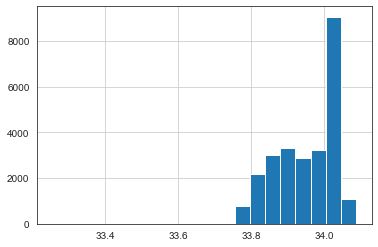

In [18]:
# Поиск выбросов
# Построение гистограмм
kobe['lat'].hist(bins=20)

<AxesSubplot:>

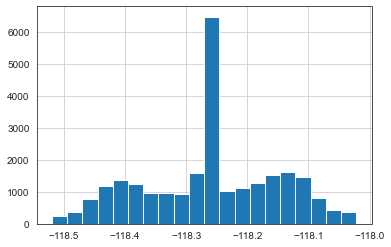

In [19]:
kobe['lon'].hist(bins=20)

In [20]:
# IsolationForest for outlier detection
X = kobe[['lat','lon']]
y = kobe['shot_made_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [22]:
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

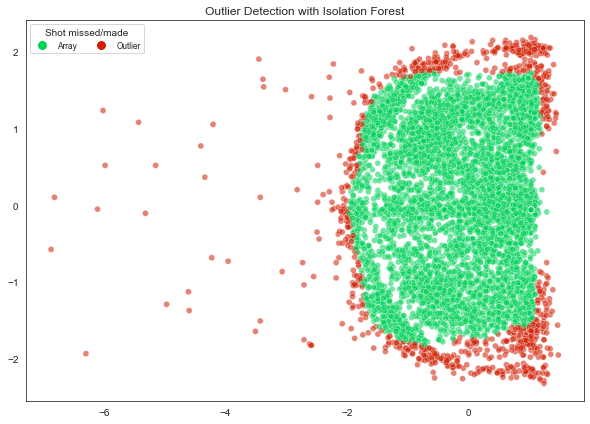

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_pred_test,
                                    alpha=0.55, ax=ax, palette=("#00d258", "#d21c00"))
#scatter.set_xlim(left=-118.54, right=-118)
#scatter.set_ylim(bottom=33.6, top=34.1)
ax.set_title("Outlier Detection with Isolation Forest")
ax.set_xlabel("")
ax.set_ylabel("")
legend_elemnts = [Line2D([0], [0], marker="o", color='w', label="Array",
                         markerfacecolor="#00d258", markersize=10),
                  Line2D([0], [0], marker="o", color='w', label="Outlier",
                         markerfacecolor="#d21c00", markersize=10)]
plt.legend(handles=legend_elemnts, title="Shot missed/made", 
           ncol=2, fontsize='small', fancybox=True);

3. Отбор признаков

In [24]:
kobe.dtypes

index                              int64
action_type                       object
combined_shot_type              category
game_event_id                   category
game_id                         category
lat                              float64
loc_x                              int64
loc_y                              int64
lon                              float64
minutes_remaining                  int64
period                            object
playoffs                        category
season                          category
seconds_remaining                  int64
shot_distance                      int64
shot_made_flag                  category
shot_type                       category
shot_zone_area                    object
shot_zone_basic                   object
shot_zone_range                   object
team_id                         category
team_name                         object
game_date                         object
matchup                           object
opponent        

In [25]:
kobe_short = kobe[['lat','lon','minutes_remaining','seconds_remaining','shot_distance','shot_id','dayOfWeek','dayOfYear']]
names = ['lat','lon','minutes_remaining','seconds_remaining','shot_distance','shot_id','dayOfWeek','dayOfYear']

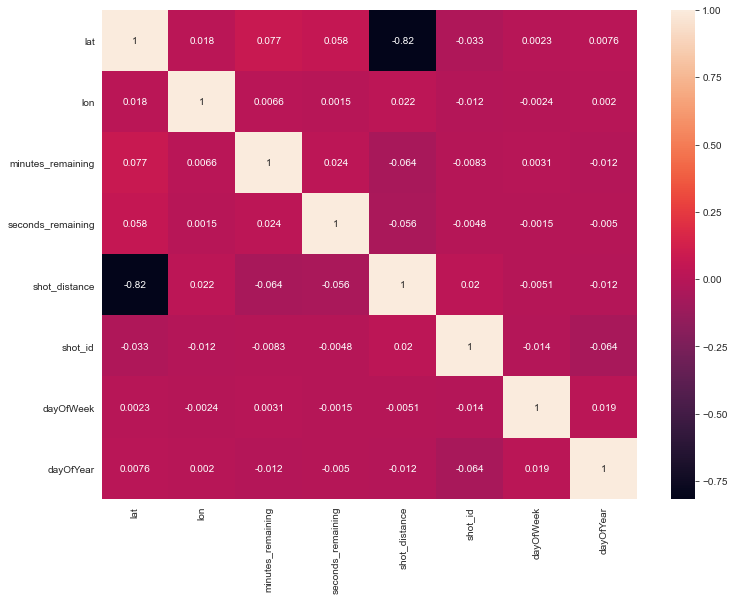

In [26]:
corr = kobe_short.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr,annot=True)
plt.show()
# Наибольшую корреляцию мы видим между характеристиками shot_distance и lat

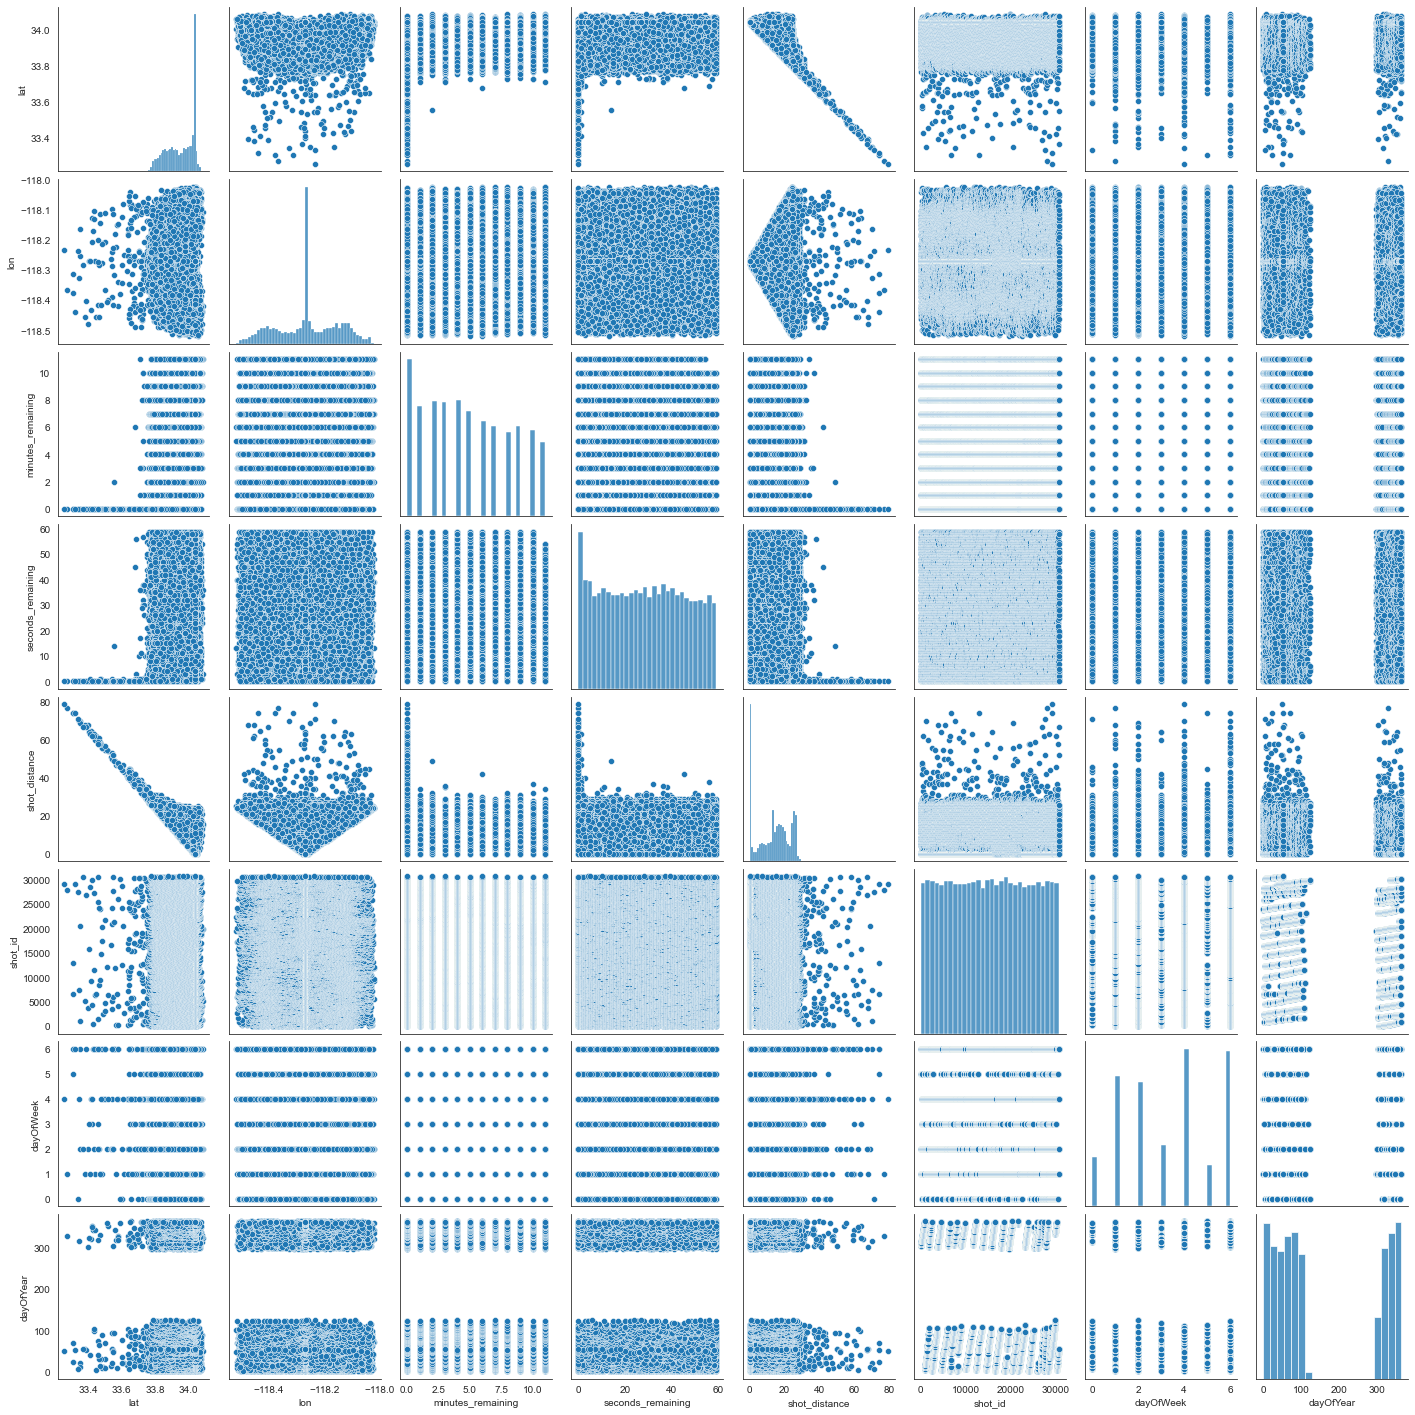

In [27]:
sns.pairplot(kobe_short)

Далее построим модель на основе деревьев решений, и посмотрим важность признаков, которую она нам вернет. В итоге, получаем высокий коэффициент для shot_id

In [28]:
array = kobe_short.values
X = array[:,0:7] # dataframe --> массив numpy
Y = array[:,7]
# извлечение признаков
model = ExtraTreesClassifier()
model.fit(X, Y) # обучение
for i in range(len(names) - 1):
    print(f"{names[i]}\t- {model.feature_importances_[i]:.4f}")

lat	- 0.1290
lon	- 0.1292
minutes_remaining	- 0.1121
seconds_remaining	- 0.1599
shot_distance	- 0.1021
shot_id	- 0.3133
dayOfWeek	- 0.0544


Посмотрим важность признаков с точки зрения методов L1-регуляризации

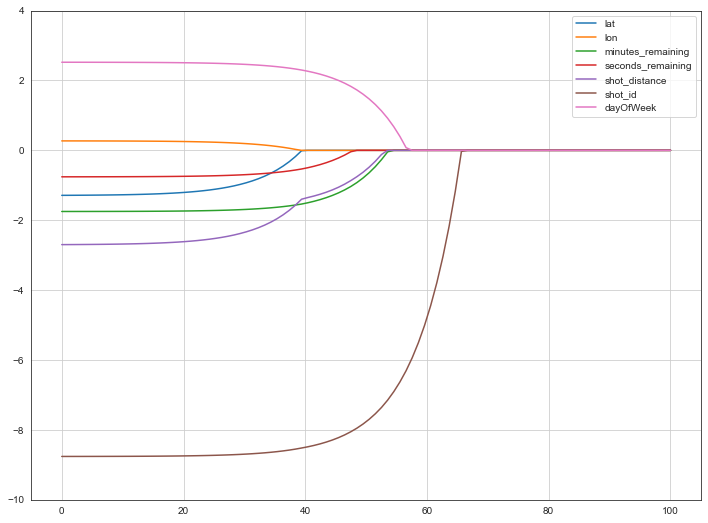

In [29]:
X_sc = StandardScaler().fit_transform(X) # преобразование данных
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

# строим n-ое кол-во моделей Лассо, меняя коэффициент регуляризации, сохраняя модель и коэффициенты
for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_sc, Y)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

# рисуем отмасштабированные признаки на одном графике
plt.figure(figsize=(12,9))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
#plt.ylim(-0.05,0.2)
plt.ylim(-10,4)  
plt.legend(names)      
plt.grid()

Из этого графика можно видеть как сначала зануляются менее важные признаки, при малых значениях коэффициента, а затем по мере увеличения коэффициента регуляризации все остальные. Таким образом, можно делать выводы о важности тех или иных признаков.

4. Рассмотрим метод главных компонент на практике. Сначала сделаем его по алгоритму "руками", а затем рассмотрим готовый алгоритм.

In [30]:
Z = np.vstack((kobe['lat'],kobe['shot_distance']))

Далее действуем по алгоритму, по которому работает PCA. Для начала стандартизуем переменные.

In [31]:
Zcentered = (Z[0] - Z[0].mean(), Z[1] - Z[1].mean()) # вычтем из переменных среднее значение
m = (Z[0].mean(), Z[1].mean())
print("Средние значения: ", m) # 

Средние значения:  (33.9530426547846, 13.457096159084719)


Посчитаем матрицу ковариаций. Делаем это с помощью бибилиотеки numpy.

In [32]:
covmat = np.cov(Zcentered)
print(covmat, "\n")
print("Дисперсия lat: ", np.cov(Zcentered)[0,0])
print("Дисперсия shot_distance: ", np.cov(Zcentered)[1,1])
print("Ковариация shot_distance & lat: ", np.cov(Zcentered)[0,1])

[[ 7.77079387e-03 -6.77108780e-01]
 [-6.77108780e-01  8.81481534e+01]] 

Дисперсия lat:  0.00777079386581921
Дисперсия shot_distance:  88.14815335131503
Ковариация shot_distance & lat:  -0.6771087804755584


Далее раскладываем матрицу ковариаций на собственные вектора. Берем один собственный вектор и с помощью этого вектора преобразуем наши центрованные данные в новые данные. Теперь получается вектор, который уже повернут в новом пространстве.

In [33]:
_, vecs = np.linalg.eig(covmat)
v = vecs[:,1]
Znew = np.dot(v, Zcentered)
print(Znew)

[ -1.54215733  -2.54316483  -8.54329507 ...  -7.54325544 -12.54388375
   6.45705358]


В итоге, получаем восстановленные с достаточно хорошей точностью данные.

In [34]:
n = 180     #номер элемента случайной величины
Zrestored = np.dot(Znew[n],v) + m
print('Восстановленные: ', Zrestored)
print('Original: ', Z[:,n])

Восстановленные:  [33.91814321 18.00028302]
Original:  [33.8813 18.    ]


Точно такую же операцию можно провернуть с помощью встроенного PCA.

In [35]:
pca = PCA(n_components = 1) # взяли 1 компоненту
ZPCAreduced = pca.fit_transform(np.transpose(Z)) # сделали трансформацию

Здесь мы можем видеть разницу между теми значениями, которые были в векторах и тем значением, которое мы получили после преобразования. Как видим все работает.

In [36]:
for zn, z_pca in zip(Znew, ZPCAreduced):
    print(zn, '-', z_pca[0], '=', np.abs(zn + z_pca[0]))

-1.5421573288383499 - 1.5421573288384622 = 1.1235457009206584e-13
-2.5431648260167066 - 2.5431648260167474 = 4.085620730620576e-14
-8.543295067182227 - 8.543295067182365 = 1.3855583347321954e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.542102335551127 - 0.5421023355511381 = 1.1102230246251565e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
1.4569245619213036 - -1.456924561921328 = 2.4424906541753444e-14
1.4567939767104223 - -1.4567939767104472 = 2.4868995751603507e-14
-11.543690491533685 - 11.543690491533871 = 1.865174681370263e-13
-3.543073871127062 - 3.5430738711271204 = 5.81756864903582e-14
1.4569091989553176 - -1.456909198955342 = 2.4424906541753444e-14
4.457634927075476 - -4.4576349270755475 = 7.194245199571014e-14
8.457186611203976 - -8.457186611204113 = 1.3677947663381929e-13
-6.543484658444507 - 6.543484658444614 = 1.0658141036401503e-13
-11.543598313737768 - 11.543598313737956 = 1.8829382497642655e-13
-2.542872929662972 - 2.54287

-8.542442422570002 - 8.542442422570142 = 1.4033219031261979e-13
-5.543176176218515 - 5.543176176218605 = 8.970602038971265e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-4.5431211829312925 - 4.543121182931367 = 7.460698725481052e-14
1.4578693843294446 - -1.4578693843294663 = 2.1760371282653068e-14
-0.5420716096191549 - 0.5420716096191662 = 1.1324274851176597e-14
-10.542199060926768 - 10.542199060926944 = 1.758593271006248e-13
-2.543356863091532 - 2.5433568630915726 = 4.04121180963557e-14
-3.5419831005420543 - 3.5419831005421147 = 6.039613253960852e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.543514161470208 - 5.543514161470298 = 8.970602038971265e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
7.457446558719466 - -7.457446558719588 = 1.2168044349891716e-13
-4.5429598717884385 - 4.542959871788513 = 7.460698725481052e-14
-4.543297857040131 - 4.543297857040206 = 7.460698725481052e-14
13.457400125776147 - -13.4574001257

-11.543337143316005 - 11.543337143316194 = 1.8829382497642655e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.543429665157285 - 5.543429665157375 = 8.970602038971265e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-2.5424350851323703 - 2.542435085132413 = 4.263256414560601e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-1.5428409808247283 - 1.5428409808247538 = 2.55351295663786e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.5423635059728895 - 0.5423635059729 = 1.0436096431476471e-14
6.457007491282592 - -6.4570074912827 = 1.0746958878371515e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
4.456935912123112 - -4.4569359121231855 = 7.37188088351104e-14
-5.543429665157285 - 5.543429665157375 = 8.970602038971265e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-17.544081903120965 - 17.544081903121

7.457216114229676 - -7.457216114229797 = 1.2079226507921703e-13
2.457025644106485 - -2.457025644106525 = 3.9968028886505635e-14
-2.542488855513321 - 2.5424888555133642 = 4.3076653355456074e-14
3.4569961410807846 - -3.456996141080841 = 5.639932965095795e-14
12.457429628801847 - -12.457429628802052 = 2.042810365310288e-13
12.457475717699804 - -12.457475717700007 = 2.0250467969162855e-13
9.457518137878948 - -9.457518137879102 = 1.545430450278218e-13
8.457109796374047 - -8.457109796374183 = 1.3677947663381929e-13
-9.54245900844226 - 9.542459008442416 = 1.5631940186722204e-13
3.457741244931107 - -3.4577412449311624 = 5.551115123125783e-14
-5.54354488740218 - 5.54354488740227 = 8.970602038971265e-14
-11.543659765601712 - 11.5436597656019 = 1.8829382497642655e-13
9.45744900453201 - -9.457449004532165 = 1.545430450278218e-13
-0.5422559652109873 - 0.5422559652109981 = 1.0769163338864018e-14
-7.5434858813507795 - 7.543485881350901 = 1.2168044349891716e-13
12.45736049545491 - -12.457360495455113 

-7.542940496058276 - 7.542940496058399 = 1.2256862191861728e-13
-5.542915005796753 - 5.542915005796844 = 9.059419880941277e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
7.457300610542599 - -7.45730061054272 = 1.2168044349891716e-13
-2.5420279665337406 - 2.5420279665337846 = 4.39648317751562e-14
5.456967860961356 - -5.456967860961446 = 8.970602038971265e-14
-1.5433710031512464 - 1.5433710031512706 = 2.4202861936828413e-14
6.457022854248579 - -6.457022854248686 = 1.0746958878371515e-13
0.4573458205796476 - -0.4573458205796544 = 6.772360450213455e-15
8.457109796374047 - -8.457109796374183 = 1.3677947663381929e-13
-0.5428013505034914 - 0.5428013505035006 = 9.2148511043888e-15
-5.543368213293341 - 5.543368213293431 = 8.970602038971265e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
1.4577848880165214 - -1.4577848880165434 = 2.19824158875781e-14
-0.5429012097824006 - 0.542901209782409

3.4576797930671628 - -3.4576797930672174 = 5.46229728115577e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.543076316939606 - 5.543076316939697 = 9.059419880941277e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-7.543163259065073 - 7.543163259065196 = 1.2256862191861728e-13
4.457389119619699 - -4.457389119619772 = 7.283063041541027e-14
-6.543469295478522 - 6.543469295478626 = 1.0480505352461478e-13
2.4568643329636313 - -2.456864332963672 = 4.085620730620576e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-3.543327360065832 - 3.5433273600658888 = 5.684341886080802e-14
-2.542903655594944 - 2.542903655594986 = 4.218847493575595e-14
13.457400125776147 - -13.45740012577

3.456896281801875 - -3.4568962818019324 = 5.728750807065808e-14
-1.5425490844709937 - 1.5425490844710201 = 2.6423307986078726e-14
-8.541912400243485 - 8.541912400243628 = 1.438849039914203e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
1.4572625471729963 - -1.4572625471730198 = 2.353672812205332e-14
-0.5431239727891981 - 0.5431239727892064 = 8.326672684688674e-15
-8.543248978284268 - 8.543248978284408 = 1.4033219031261979e-13
3.4576183412032186 - -3.4576183412032737 = 5.5067062021407764e-14
-0.5432468765170863 - 0.5432468765170944 = 8.104628079763643e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-6.542178806335695 - 6.542178806335804 = 1.092459456231154e-13
-1.542226462185287 - 1.5422264621853141 = 2.708944180085382e-14
0.45719219091978736 - -0.45719219091979457 = 7.216449660063518e-15
5.457344253628014 - -5.4573442536281025 = 8.881784197001252e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.5431470172381772 - 0.54314

7.457446558719466 - -7.457446558719588 = 1.2168044349891716e-13
-4.5429291458564665 - 4.542929145856541 = 7.460698725481052e-14
5.457574698117804 - -5.4575746981178925 = 8.881784197001252e-14
9.457241604491198 - -9.457241604491355 = 1.5631940186722204e-13
-11.543191195139139 - 11.543191195139329 = 1.900701818158268e-13
-6.54359219920641 - 6.543592199206515 = 1.0480505352461478e-13
-7.543193984997045 - 7.543193984997167 = 1.2168044349891716e-13
7.457146980882739 - -7.457146980882861 = 1.2168044349891716e-13
-12.543130966181467 - 12.543130966181671 = 2.042810365310288e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-2.5426732111051535 - 2.542673211105196 = 4.263256414560601e-14
-5.543368213293341 - 5.543368213293431 = 8.970602038971265e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
3.4569500521828265 - -3.456950052182883 = 5.639932965095795e-14
5.457013949859314 - -5.45701394985940

5.457013949859314 - -5.457013949859404 = 9.059419880941277e-14
-0.5423020541089454 - 0.542302054108956 = 1.0658141036401503e-14
-0.5421484244490851 - 0.5421484244490961 = 1.099120794378905e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-3.543427219344741 - 3.5434272193447978 = 5.684341886080802e-14
-5.5431992206674945 - 5.543199220667584 = 8.970602038971265e-14
-11.5437826693296 - 11.54378266932979 = 1.900701818158268e-13
-3.543327360065832 - 3.5433273600658888 = 5.684341886080802e-14
-11.542899298785404 - 11.542899298785594 = 1.900701818158268e-13
2.457770747956807 - -2.457770747956846 = 3.863576125695545e-14
-0.542140742966092 - 0.5421407429661032 = 1.1102230246251565e-14
-11.542630446880649 - 11.54263044688084 = 1.9184653865522705e-13
-11.543506135941852 - 11.54350613594204 = 1.8829382497642655e-13
-13.543209003917669 - 13.543209003917891 = 2.220446049250313e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-10.5423834165186 - 10.542383416518

-5.543375894776334 - 5.543375894776424 = 8.970602038971265e-14
-3.5420522338889913 - 3.5420522338890517 = 6.039613253960852e-14
4.45746593444963 - -4.4574659344497025 = 7.283063041541027e-14
-5.543452709606264 - 5.543452709606353 = 8.881784197001252e-14
-7.542057125514079 - 7.542057125514205 = 1.2612133559741778e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.542484842749144 - 5.542484842749236 = 9.14823772291129e-14
-10.542713720287301 - 10.542713720287471 = 1.7053025658242404e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-10.542905757362126 - 10.5429057573623 = 1.7408297026122455e-13
-10.543405053756672 - 10.543405053756844 = 1.723066134218243e-13
2.4570025996575056 - -2.4570025996575464 = 4.085620730620576e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-10.54276749066825 - 10.542767490668425 = 1.7408297026122455e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.4574001257

13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-11.543567587805796 - 11.543567587805985 = 1.8829382497642655e-13
-11.543314098867027 - 11.543314098867217 = 1.900701818158268e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
4.456958956572091 - -4.456958956572165 = 7.37188088351104e-14
6.457138076493473 - -6.457138076493579 = 1.056932319443149e-13
1.4579538806423677 - -1.4579538806423895 = 2.1760371282653068e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.542086972585141 - 0.5420869725851521 = 1.1102230246251565e-14
-10.543497231552587 - 10.54349723155276 = 1.723066134218243e-13
-10.543320557443748 - 10.543320557443922 = 1.7408297026122455e-13
-5.54313776880355 - 5.543137768803641 = 9.059419880941277e-14
-6.54343856954655 - 6.543438569

-12.543776210752881 - 12.54377621075308 = 1.9895196601282805e-13
-11.54355222483981 - 11.543552224839999 = 1.8829382497642655e-13
-11.543490772975867 - 11.543490772976055 = 1.8829382497642655e-13
-13.543063055740802 - 13.54306305574102 = 2.184918912462308e-13
-6.543476976961514 - 6.543476976961621 = 1.0658141036401503e-13
-12.543806936684852 - 12.543806936685057 = 2.042810365310288e-13
-6.543377117682605 - 6.543377117682712 = 1.0658141036401503e-13
-11.543452365560901 - 11.543452365561091 = 1.900701818158268e-13
-13.54374670772718 - 13.543746707727399 = 2.184918912462308e-13
7.457561780964362 - -7.457561780964482 = 1.199040866595169e-13
-0.5432699209660653 - 0.5432699209660734 = 8.104628079763643e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.5432990799464035 - 5.543299079946493 = 8.970602038971265e-14
-11.543467728526887 - 11.543467728527077 = 1.900701818158268e-13
5.457067720240265 - -5.457067720240355 = 8.970602038971265e-14
-3.5431122785420275 - 3.543112278

13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-11.542883935819418 - 11.542883935819608 = 1.900701818158268e-13
-4.54301364216939 - 4.543013642169464 = 7.37188088351104e-14
7.457146980882739 - -7.457146980882861 = 1.2168044349891716e-13
-10.542890394396139 - 10.542890394396313 = 1.7408297026122455e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543837662616825 - 12.543837662617026 = 2.007283228522283e-13
10.457488634853247 - -10.457488634853418 = 1.7053025658242404e-13
2.4569795552085267 - -2.4569795552085667 = 3.9968028886505635e-14
-11.543367869247978 - 11.543367869248168 = 1.900701818158268e-13
-9.542059571326623 - 9.542059571326782 = 1.580957587066223e-13
-9.5419750750137 - 9.541975075013857 = 1.580957587066223e-13
-11.543767306363614 - 11.543767306363803 = 1.8829382497642655e-13
-12.543269232875343 - 12.543269232875547 = 2.042810365310288e-13
-9.542297697299405 - 9.542297697

-5.543252991048446 - 5.5432529910485355 = 8.970602038971265e-14
-12.543561129229076 - 12.54356112922928 = 2.042810365310288e-13
-4.543005960686397 - 4.543005960686472 = 7.460698725481052e-14
8.457232700101935 - -8.457232700102072 = 1.3677947663381929e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-4.543282494074146 - 4.543282494074219 = 7.37188088351104e-14
3.4576567486181835 - -3.457656748618239 = 5.551115123125783e-14
-12.543853025582811 - 12.543853025583013 = 2.0250467969162855e-13
-11.543429321111923 - 11.543429321112113 = 1.900701818158268e-13
-4.542967553271432 - 4.542967553271506 = 7.37188088351104e-14
1.4578002509825074 - -1.4578002509825294 = 2.19824158875781e-14
-0.5431239727891981 - 0.5431239727892064 = 8.326672684688674e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-6.54326189543771 - 6.5432618954378166 = 1.0658141036401503e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.4574001257763

13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-16.54350456899022 - 16.54350456899049 = 2.7000623958883807e-13
-3.5430815526100554 - 3.543081552610114 = 5.861977570020827e-14
-4.5421225901422 - 4.542122590142277 = 7.72715225139109e-14
-11.543191195139139 - 11.543191195139329 = 1.900701818158268e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-13.543278137264606 - 13.54327813726483 = 2.2382096176443156e-13
-10.542398779484587 - 10.542398779484762 = 1.7408297026122455e-13
-13.543370315060523 - 13.543370315060745 = 2.220446049250313e-13
8.457155885272003 - -8.457155885272142 = 1.3855583347321954e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-11.543490772975867 - 11.543490772976055 = 1.8829382497642655e-13
-11.543759624880622 - 11.543759624880808 = 1.865174681370263e-13
-11.54362903966974 - 11.5436290

-12.543576492195063 - 12.543576492195264 = 2.007283228522283e-13
8.457378648278802 - -8.457378648278938 = 1.3677947663381929e-13
-2.5431801889826926 - 2.5431801889827335 = 4.085620730620576e-14
-13.54341640395848 - 13.543416403958703 = 2.2382096176443156e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.5432990799464035 - 5.543299079946493 = 8.970602038971265e-14
-11.54352918039083 - 11.543529180391019 = 1.8829382497642655e-13
-7.54315557758208 - 7.543155577582201 = 1.2079226507921703e-13
-10.542022386817928 - 10.542022386818104 = 1.758593271006248e-13
-7.543347614656906 - 7.54334761465703 = 1.2434497875801753e-13
0.4567850723211575 - -0.4567850723211659 = 8.382183835919932e-15
-14.543671115803521 - 14.543671115803761 = 2.398081733190338e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-13.543884974421054 - 13.543884

-13.543562352135348 - 13.543562352135568 = 2.2026824808563106e-13
-6.543384799165598 - 6.543384799165704 = 1.056932319443149e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543092558766503 - 12.543092558766707 = 2.042810365310288e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543522721814112 - 12.543522721814316 = 2.042810365310288e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543169373596433 - 12.543169373596639 = 2.0605739337042905e-13
0.45680811677013655 - -0.4568081167701449 = 8.326672684688674e-15
-2.5434029519894903 - 2.5434029519895307 = 4.04121180963557e-14
-6.543223488022745 - 6.543223488022853 = 1.0746958878371515e-13
4.457535067796567 - -4.457535067796639 = 7.283063041541027e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
2.45770161460987 - -2.4577016146099084 = 3.863576125695545e-14
-4.543505257080943 - 4.5435052

-4.543359308904075 - 4.54335930890415 = 7.460698725481052e-14
6.457022854248579 - -6.457022854248686 = 1.0746958878371515e-13
1.45757748797571 - -1.4575774879757326 = 2.2648549702353193e-14
-3.542943285916181 - 3.5429432859162393 = 5.81756864903582e-14
-14.54354053059264 - 14.543540530592878 = 2.3803181647963356e-13
-4.542537390223823 - 4.5425373902239 = 7.638334409421077e-14
6.457276343187348 - -6.457276343187454 = 1.056932319443149e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-1.5422879140492312 - 1.542287914049258 = 2.6867397195928788e-14
8.457370966795809 - -8.457370966795947 = 1.3855583347321954e-13
-13.543493218788411 - 13.543493218788631 = 2.2026824808563106e-13
-6.542908547220032 - 6.542908547220138 = 1.0658141036401503e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-13.543408722475487 - 13.543408722475709 = 2.220446049250313e-13
-2.543364544574525 - 2.543364544574566 = 4.085620730620576e-14
13.457400125776147 - -13.457400125776365 

-11.543137424758187 - 11.543137424758376 = 1.8829382497642655e-13
-2.543280048261602 - 2.5432800482616424 = 4.04121180963557e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-2.5430265593228323 - 2.543026559322874 = 4.1744385725905886e-14
-7.5434858813507795 - 7.543485881350901 = 1.2168044349891716e-13
-1.542211099219301 - 1.5422110992193283 = 2.731148640577885e-14
-5.543037909524641 - 5.543037909524732 = 9.059419880941277e-14
-6.542969999083976 - 6.5429699990840815 = 1.056932319443149e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
0.45701551681094793 - -0.4570155168109557 = 7.771561172376096e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543776210752881 - 12.54377621075308 = 1.9895196601282805e-13
-1.543194329042407 - 1.5431943290424315 = 2.4424906541753444e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-1.542710395613847 - 1.542710

13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.5426323578776451 - 0.5426323578776547 = 9.658940314238862e-15
-0.5428090319864844 - 0.5428090319864937 = 9.2148511043888e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
2.457279133045254 - -2.457279133045294 = 3.9968028886505635e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-9.543565141993254 - 9.543565141993406 = 1.5276668818842154e-13
0.4568388427021086 - -0.45683884270211683 = 8.215650382226158e-15
-10.543789127906322 - 10.543789127906493 = 1.7053025658242404e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.542125380000106 - 0.5421253800001171 = 1.1102230246251565e-14
-2.5426732111051535 - 2.542673211105196 = 4.263256414560601e-14
-7.5418420439902745 - 7.5418420439904015 = 1.270095140171179e-13
0.4573381390966546 - -0.45733813909666143 = 6.827871601444713e-15
-10.543735357525371 - 10.543735357525541 = 1.7053025658242404e-13
-2.542826840765014 - 2.542

-8.543671459848884 - 8.543671459849023 = 1.3855583347321954e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
2.4575249405010307 - -2.4575249405010697 = 3.907985046680551e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-11.543298735901041 - 11.543298735901232 = 1.900701818158268e-13
-4.543159590346257 - 4.543159590346333 = 7.549516567451064e-14
-5.543214583633481 - 5.54321458363357 = 8.881784197001252e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
5.457006268376321 - -5.457006268376411 = 8.970602038971265e-14
8.457163566754998 - -8.457163566755135 = 1.3677947663381929e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
4.457197082544874 - -4.457197082544947 = 7.283063041541027e-14
-13.543608441033307 - 13.543608441033529 = 2.220446049250313e-13
9.457180152627254 - -9.45718015262741 = 1.5631940186722204e-13
-6.542163443369709 - 6.542163443369819 = 1.092459456231154e-13
13.457400125776147 - -13.457400125776365

9.457172471144261 - -9.457172471144416 = 1.545430450278218e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-3.543419537861748 - 3.5434195378618045 = 5.639932965095795e-14
3.4574800745093444 - -3.4574800745094003 = 5.595524044110789e-14
4.457097223265965 - -4.457097223266039 = 7.37188088351104e-14
-3.5431276415080135 - 3.5431276415080712 = 5.773159728050814e-14
4.4571125862319505 - -4.457112586232023 = 7.283063041541027e-14
-3.542566893249523 - 3.542566893249582 = 5.906386491005833e-14
-3.5430661896440694 - 3.543066189644127 = 5.773159728050814e-14
-13.543493218788411 - 13.543493218788631 = 2.2026824808563106e-13
-1.5426182178179308 - 1.542618217817957 = 2.6201263381153694e-14
-6.543523065859473 - 6.543523065859578 = 1.0480505352461478e-13
-5.543176176218515 - 5.543176176218605 = 8.970602038971265e-14
4.457281578857797 - -4.45728157885787 = 7.283063041541027e-14
3.4570422299787427 - -3.4570422299788 = 5.728750807065808e-14
8.457370966795809 - -8.457370966795947 = 1.

5.457036994308293 - -5.457036994308383 = 8.970602038971265e-14
-9.542981349285784 - 9.54298134928594 = 1.5631940186722204e-13
-8.543640733916913 - 8.543640733917051 = 1.3855583347321954e-13
3.4570345484957494 - -3.4570345484958063 = 5.684341886080802e-14
-7.5431863035140525 - 7.543186303514175 = 1.2256862191861728e-13
7.4571777068147105 - -7.457177706814832 = 1.2168044349891716e-13
-9.543188749326596 - 9.543188749326752 = 1.5631940186722204e-13
0.45776062066127043 - -0.4577606206612762 = 5.773159728050814e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
1.4568247026423944 - -1.4568247026424193 = 2.4868995751603507e-14
-10.54296720922607 - 10.542967209226244 = 1.7408297026122455e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-1.5433786846342394 - 1.54337

6.45705358018055 - -6.457053580180656 = 1.056932319443149e-13
-2.5430419222888183 - 2.5430419222888596 = 4.1300296516055823e-14
-10.543789127906322 - 10.543789127906493 = 1.7053025658242404e-13
-3.543404174895762 - 3.543404174895819 = 5.684341886080802e-14
-9.543442238265365 - 9.54344223826552 = 1.545430450278218e-13
-10.543466505620616 - 10.543466505620787 = 1.7053025658242404e-13
-10.543259105579804 - 10.543259105579978 = 1.7408297026122455e-13
-0.5426707652926102 - 0.5426707652926197 = 9.547918011776346e-15
-5.543130087320558 - 5.543130087320648 = 9.059419880941277e-14
-9.543588186442232 - 9.543588186442387 = 1.545430450278218e-13
-11.543821076744566 - 11.543821076744756 = 1.900701818158268e-13
7.4572391586786555 - -7.457239158678777 = 1.2168044349891716e-13
-1.543209692008393 - 1.5432096920084177 = 2.4646951146678475e-14
-10.543466505620616 - 10.543466505620787 = 1.7053025658242404e-13
-11.543268009969069 - 11.543268009969259 = 1.900701818158268e-13
13.457400125776147 - -13.4574001

-1.5429869290015956 - 1.542986929001621 = 2.531308496145357e-14
-7.543393703554863 - 7.543393703554985 = 1.2168044349891716e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-11.54362903966974 - 11.543629039669929 = 1.8829382497642655e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543522721814112 - 12.543522721814316 = 2.042810365310288e-13
0.457061605708906 - -0.4570616057089137 = 7.66053886991358e-15
0.45746104282454286 - -0.45746104282454936 = 6.494804694057166e-15
1.4567786137444363 - -1.4567786137444612 = 2.4868995751603507e-14
-4.543036686618369 - 4.543036686618444 = 7.460698725481052e-14
4.457634927075476 - -4.4576349270755475 = 7.194245199571014e-14
1.457554443526731 - -1.4575544435267536 = 2.2648549702353193e-14
1.4568016581934153 - -1.4568016581934402 = 2.4868995751603507e-14
-10.543597090831497 - 10.543597090831668 = 1.7053025658242404e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.45

-10.543320557443748 - 10.543320557443922 = 1.7408297026122455e-13
-11.543383232213964 - 11.543383232214154 = 1.900701818158268e-13
-0.5430317949932819 - 0.5430317949932905 = 8.548717289613705e-15
-1.543209692008393 - 1.5432096920084177 = 2.4646951146678475e-14
7.457446558719466 - -7.457446558719588 = 1.2168044349891716e-13
4.457450571483643 - -4.457450571483716 = 7.283063041541027e-14
11.457244050303741 - -11.457244050303931 = 1.900701818158268e-13
11.457282457718707 - -11.457282457718895 = 1.8829382497642655e-13
11.457305502167685 - -11.457305502167873 = 1.8829382497642655e-13
-7.543224710929017 - 7.54322471092914 = 1.2256862191861728e-13
8.45714820378901 - -8.45714820378915 = 1.3855583347321954e-13
12.457283680624979 - -12.457283680625181 = 2.0250467969162855e-13
1.4569091989553176 - -1.456909198955342 = 2.4424906541753444e-14
0.4567313019402064 - -0.45673130194021483 = 8.43769498715119e-15
-12.54372244037193 - 12.543722440372134 = 2.042810365310288e-13
-4.543213360727209 - 4.5432133

-9.542036526877643 - 9.542036526877801 = 1.580957587066223e-13
-2.543303092710581 - 2.5433030927106217 = 4.085620730620576e-14
12.457345132488923 - -12.45734513248913 = 2.0605739337042905e-13
2.45785524426973 - -2.4578552442697688 = 3.863576125695545e-14
-5.54346807257225 - 5.543468072572338 = 8.79296635503124e-14
-8.542580689263875 - 8.542580689264016 = 1.4033219031261979e-13
-10.543074749987971 - 10.543074749988143 = 1.723066134218243e-13
-11.543521498907838 - 11.543521498908026 = 1.8829382497642655e-13
-2.54324932232963 - 2.543249322329671 = 4.085620730620576e-14
5.457190623968153 - -5.457190623968243 = 8.970602038971265e-14
-3.5420522338889913 - 3.5420522338890517 = 6.039613253960852e-14
10.457212101465498 - -10.457212101465668 = 1.7053025658242404e-13
-10.542337327620642 - 10.542337327620817 = 1.758593271006248e-13
11.4572901392017 - -11.457290139201888 = 1.8829382497642655e-13
-9.542305378782398 - 9.542305378782556 = 1.580957587066223e-13
2.4570025996575056 - -2.4570025996575464 

2.457025644106485 - -2.457025644106525 = 3.9968028886505635e-14
1.4568938359893315 - -1.456893835989356 = 2.4424906541753444e-14
0.45766844286535424 - -0.45766844286536024 = 5.995204332975845e-15
1.4568400656083804 - -1.4568400656084053 = 2.4868995751603507e-14
1.4568631100573595 - -1.4568631100573841 = 2.4646951146678475e-14
-6.5436075621723955 - 6.543607562172502 = 1.0658141036401503e-13
6.457291706153334 - -6.457291706153439 = 1.056932319443149e-13
12.457314406556952 - -12.457314406557154 = 2.0250467969162855e-13
-11.543813395261573 - 11.543813395261761 = 1.8829382497642655e-13
9.45719551559324 - -9.457195515593396 = 1.5631940186722204e-13
-8.543525511672017 - 8.543525511672152 = 1.3500311979441904e-13
-5.542231353810375 - 5.542231353810467 = 9.237055564881302e-14
-7.543578059146696 - 7.543578059146818 = 1.2256862191861728e-13
-10.543597090831497 - 10.543597090831668 = 1.7053025658242404e-13
-11.543759624880622 - 11.543759624880808 = 1.865174681370263e-13
-11.543229602554103 - 11.54

-8.543003170828491 - 8.543003170828632 = 1.4033219031261979e-13
11.457436087378566 - -11.457436087378754 = 1.8829382497642655e-13
-10.543535638967553 - 10.543535638967724 = 1.7053025658242404e-13
-2.5424504480983563 - 2.542450448098399 = 4.263256414560601e-14
13.45733099242921 - -13.45733099242943 = 2.2026824808563106e-13
11.457451450344553 - -11.45745145034474 = 1.865174681370263e-13
-5.542692242789956 - 5.542692242790047 = 9.14823772291129e-14
12.457421947318855 - -12.457421947319055 = 2.007283228522283e-13
-11.543437002594915 - 11.543437002595102 = 1.865174681370263e-13
2.4575249405010307 - -2.4575249405010697 = 3.907985046680551e-14
7.457315973508585 - -7.457315973508708 = 1.2256862191861728e-13
2.4569641922425407 - -2.456964192242581 = 4.04121180963557e-14
-7.54340906652085 - 7.543409066520971 = 1.2168044349891716e-13
-5.543452709606264 - 5.543452709606353 = 8.881784197001252e-14
-6.54359219920641 - 6.543592199206515 = 1.0480505352461478e-13
12.457429628801847 - -12.45742962880205

-5.543529524436194 - 5.543529524436283 = 8.881784197001252e-14
10.457227464431483 - -10.457227464431654 = 1.7053025658242404e-13
13.457415488742132 - -13.457415488742352 = 2.2026824808563106e-13
-7.542633236738555 - 7.542633236738679 = 1.234568003383174e-13
-11.54266117281262 - 11.54266117281281 = 1.900701818158268e-13
-12.543522721814112 - 12.543522721814316 = 2.042810365310288e-13
6.457122713527488 - -6.457122713527594 = 1.0658141036401503e-13
11.457413042929588 - -11.457413042929774 = 1.865174681370263e-13
-4.5427831976796 - 4.5427831976796735 = 7.37188088351104e-14
2.4568566514806385 - -2.4568566514806793 = 4.085620730620576e-14
9.457203197076234 - -9.457203197076387 = 1.5276668818842154e-13
-5.543514161470208 - 5.543514161470298 = 8.970602038971265e-14
-5.54346807257225 - 5.543468072572338 = 8.79296635503124e-14
-13.543861929972076 - 13.543861929972296 = 2.2026824808563106e-13
-13.543800478108132 - 13.543800478108349 = 2.1671553440683056e-13
11.457282457718707 - -11.45728245771889

-11.543437002594915 - 11.543437002595102 = 1.865174681370263e-13
-9.54248973437423 - 9.542489734374389 = 1.580957587066223e-13
11.457374635514622 - -11.45737463551481 = 1.8829382497642655e-13
-5.54226976122534 - 5.542269761225431 = 9.14823772291129e-14
2.4568412885146524 - -2.4568412885146933 = 4.085620730620576e-14
11.457459131827546 - -11.457459131827733 = 1.865174681370263e-13
-12.54323850694337 - 12.543238506943574 = 2.042810365310288e-13
-1.5432788253553302 - 1.5432788253553547 = 2.4424906541753444e-14
-1.5432480994233582 - 1.5432480994233828 = 2.4646951146678475e-14
-10.543789127906322 - 10.543789127906493 = 1.7053025658242404e-13
-5.542692242789956 - 5.542692242790047 = 9.14823772291129e-14
-1.5431021512464909 - 1.543102151246516 = 2.5091040356528538e-14
13.457354036878188 - -13.457354036878407 = 2.184918912462308e-13
-12.543806936684852 - 12.543806936685057 = 2.042810365310288e-13
10.457480953370254 - -10.457480953370423 = 1.687538997430238e-13
2.4569488292765547 - -2.456948829

6.45730706911932 - -6.457307069119427 = 1.0658141036401503e-13
11.457305502167685 - -11.457305502167873 = 1.8829382497642655e-13
-1.5429408401036375 - 1.5429408401036626 = 2.5091040356528538e-14
2.456833607031659 - -2.4568336070317005 = 4.1300296516055823e-14
-10.541945571987998 - 10.541945571988174 = 1.758593271006248e-13
12.457314406556952 - -12.457314406557154 = 2.0250467969162855e-13
12.457475717699804 - -12.457475717700007 = 2.0250467969162855e-13
12.457421947318855 - -12.457421947319055 = 2.007283228522283e-13
1.4568247026423944 - -1.4568247026424193 = 2.4868995751603507e-14
-0.5429857060953238 - 0.5429857060953325 = 8.659739592076221e-15
0.45689261308305973 - -0.4568926130830677 = 7.993605777301127e-15
-11.543774987846607 - 11.543774987846795 = 1.8829382497642655e-13
6.457260980221362 - -6.457260980221467 = 1.056932319443149e-13
-11.543736580431643 - 11.543736580431831 = 1.8829382497642655e-13
-4.542806242128578 - 4.542806242128654 = 7.549516567451064e-14
-3.5433196785828387 - 3

-6.542839413873094 - 6.542839413873202 = 1.0835776720341528e-13
-11.543383232213964 - 11.543383232214154 = 1.900701818158268e-13
-0.543070202408247 - 0.5430702024082554 = 8.43769498715119e-15
-4.543474531148971 - 4.543474531149044 = 7.283063041541027e-14
4.456928230640119 - -4.456928230640193 = 7.37188088351104e-14
-12.54346895143316 - 12.543468951433367 = 2.0605739337042905e-13
0.4575685835864451 - -0.4575685835864513 = 6.217248937900877e-15
-7.543624148044654 - 7.543624148044777 = 1.2256862191861728e-13
-5.543014865075662 - 5.543014865075752 = 8.970602038971265e-14
-10.54378144642333 - 10.543781446423502 = 1.723066134218243e-13
-10.543643179729456 - 10.543643179729626 = 1.7053025658242404e-13
-1.5432557809063512 - 1.5432557809063754 = 2.4202861936828413e-14
2.457240725630289 - -2.4572407256303284 = 3.952393967665557e-14
-4.543205679244215 - 4.543205679244289 = 7.37188088351104e-14
-10.543612453797483 - 10.543612453797655 = 1.723066134218243e-13
-3.543465626759706 - 3.543465626759763 

2.4568796959296173 - -2.456879695929658 = 4.085620730620576e-14
-8.542526918882926 - 8.542526918883064 = 1.3855583347321954e-13
1.4568707915403525 - -1.456870791540377 = 2.4424906541753444e-14
-12.5433153217733 - 12.543315321773505 = 2.0605739337042905e-13
-9.541921304632748 - 9.541921304632908 = 1.5987211554602254e-13
12.457375858420896 - -12.457375858421097 = 2.007283228522283e-13
-1.5424108177771194 - 1.542410817777146 = 2.6645352591003757e-14
-14.543840108429368 - 14.543840108429604 = 2.362554596402333e-13
-12.543883751514784 - 12.543883751514986 = 2.0250467969162855e-13
-5.543222265116474 - 5.5432222651165635 = 8.970602038971265e-14
-10.543750720491357 - 10.543750720491527 = 1.7053025658242404e-13
-1.5423570473961683 - 1.5423570473961952 = 2.6867397195928788e-14
-0.5422866911429594 - 0.54228669114297 = 1.0658141036401503e-14
11.457374635514622 - -11.45737463551481 = 1.8829382497642655e-13
9.457164789661269 - -9.457164789661423 = 1.545430450278218e-13
-5.542123813048472 - 5.5421238

5.457006268376321 - -5.457006268376411 = 8.970602038971265e-14
-1.5428717067567004 - 1.542871706756726 = 2.55351295663786e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-9.542750904795994 - 9.54275090479615 = 1.5631940186722204e-13
-9.543350060469448 - 9.543350060469605 = 1.5631940186722204e-13
-13.543831204040103 - 13.543831204040323 = 2.2026824808563106e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-9.543211793775574 - 9.543211793775729 = 1.545430450278218e-13
7.457561780964362 - -7.457561780964482 = 1.199040866595169e-13
-9.543511371612302 - 9.543511371612

2.4574481256711005 - -2.45744812567114 = 3.952393967665557e-14
6.457429972847208 - -6.457429972847314 = 1.056932319443149e-13
-19.544045941518544 - 19.54404594151886 = 3.161915174132446e-13
2.4578321998207513 - -2.4578321998207895 = 3.8191672047105385e-14
-13.543854248489083 - 13.5438542484893 = 2.1671553440683056e-13
-12.543491995882139 - 12.543491995882345 = 2.0605739337042905e-13
-12.54362258109302 - 12.543622581093224 = 2.042810365310288e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
7.457139299399746 - -7.457139299399869 = 1.234568003383174e-13
4.457181719578888 - -4.457181719578961 = 7.283063041541027e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-1.5433018698043093 - 1.5433018698043337 = 2.4424906541753444e-14
10.457365731125359 - -10.45736573112553 = 1.7053025658242404e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-8.54322593383529 - 8.54322593383

3.4571267262916656 - -3.4571267262917216 = 5.595524044110789e-14
6.457122713527488 - -6.457122713527594 = 1.0658141036401503e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
0.4568311612191156 - -0.45683116121912376 = 8.1601392309949e-15
3.457387896713428 - -3.4573878967134837 = 5.551115123125783e-14
-2.542680892588147 - 2.542680892588189 = 4.218847493575595e-14
-0.5423097355919384 - 0.542309735591949 = 1.0547118733938987e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-17.543720873420295 - 17.54372087342058 = 2.8421709430404007e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-3.543427219344741 - 3.5434272193447978 = 5.684341886080802e-14
6.457007491282592 - -6.4570074912827 = 1.0746958878371515e-13
6.457598965473054 - -6.457598965473159 = 1.0480505352461478e-13
1.4569399248872896 - -1.45693992488

1.4570397841661988 - -1.457039784166223 = 2.4202861936828413e-14
-9.543411512333392 - 9.543411512333549 = 1.5631940186722204e-13
-1.5430406993825467 - 1.5430406993825718 = 2.5091040356528538e-14
-11.543621358186748 - 11.543621358186934 = 1.865174681370263e-13
3.4571113633256796 - -3.457111363325736 = 5.639932965095795e-14
3.456927007733847 - -3.4569270077339045 = 5.728750807065808e-14
3.456927007733847 - -3.4569270077339045 = 5.728750807065808e-14
-0.5429857060953238 - 0.5429857060953325 = 8.659739592076221e-15
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
2.457087095970429 - -2.4570870959704694 = 4.04121180963557e-14
-2.5431110556357557 - 2.543111055635797 = 4.1300296516055823e-14
-3.543027782229104 - 3.5430277822291623 = 5.81756864903582e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.5421100170341201 - 0.5421100170341311 = 1.099120794378905e-14
13.457400125776147 - -13.4574001

-11.543652084118719 - 11.543652084118909 = 1.900701818158268e-13
2.457724659058849 - -2.4577246590588877 = 3.863576125695545e-14
1.4572855916219754 - -1.4572855916219987 = 2.3314683517128287e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-4.543136545897278 - 4.543136545897353 = 7.460698725481052e-14
-13.543408722475487 - 13.543408722475709 = 2.220446049250313e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-3.543342723031818 - 3.5433427230318753 = 5.728750807065808e-14
-1.5427948919267702 - 1.5427948919267958 = 2.55351295663786e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-4.542952190305446 - 4.54295219030552 = 7.460698725481052e-14
3.456927007733847 - -3.4569270077339045 = 5.728750807065808e-14
1.457546762043738 - -1.4575467620437608 = 2.2870594307278225e-14
-10.543597090831497 - 10.54359709

-3.543311997099846 - 3.543311997099903 = 5.728750807065808e-14
12.457398902869874 - -12.457398902870077 = 2.0250467969162855e-13
-11.543659765601712 - 11.5436597656019 = 1.8829382497642655e-13
3.4576644301011767 - -3.457664430101232 = 5.5067062021407764e-14
-2.5430880111867764 - 2.5430880111868177 = 4.1300296516055823e-14
3.4572573115025467 - -3.4572573115026035 = 5.684341886080802e-14
5.457313527696042 - -5.45731352769613 = 8.881784197001252e-14
5.457520927736853 - -5.457520927736941 = 8.79296635503124e-14
1.4568477470913734 - -1.456847747091398 = 2.4646951146678475e-14
6.4571995283574175 - -6.457199528357523 = 1.056932319443149e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.5432699209660653 - 0.5432699209660734 = 8.104628079763643e-15
5.456967860961356 - -5.456967860961446 = 8.970602038971265e-14
-5.543498798504222 - 5.543498798504311 = 8.881784197001252e-14
1.4572164582750382 - -1.457216458275062 = 2.375877272697835e-14
13.457400125776147 - -13.4574001257763

13.457346355395195 - -13.457346355395416 = 2.2026824808563106e-13
0.45741495392658477 - -0.4574149539265914 = 6.661338147750939e-15
-10.54329751299477 - 10.543297512994943 = 1.7408297026122455e-13
-4.5433209014891105 - 4.543320901489184 = 7.37188088351104e-14
11.45732086513367 - -11.457320865133859 = 1.8829382497642655e-13
-10.543735357525371 - 10.543735357525541 = 1.7053025658242404e-13
7.457185388297704 - -7.457185388297826 = 1.2168044349891716e-13
-0.5422098763130292 - 0.5422098763130401 = 1.0880185641326534e-14
3.456911644767861 - -3.4569116447679185 = 5.728750807065808e-14
12.457375858420896 - -12.457375858421097 = 2.007283228522283e-13
-1.5432404179403652 - 1.5432404179403898 = 2.4646951146678475e-14
-0.5431854246531422 - 0.5431854246531505 = 8.215650382226158e-15
-10.543712313076393 - 10.543712313076565 = 1.723066134218243e-13
-3.543434900827734 - 3.5434349008277906 = 5.639932965095795e-14
-0.5425401800817289 - 0.5425401800817388 = 9.880984919163893e-15
10.45739645705733 - -10.4

13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
4.456935912123112 - -4.4569359121231855 = 7.37188088351104e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.54316169211344 - 12.543161692113642 = 2.0250467969162855e-13
4.457488978898609 - -4.457488978898681 = 7.194245199571014e-14
-22.544088017652324 - 22.544088017652694 = 3.694822225952521e-13
-11.543099017343222 - 11.543099017343412 = 1.900701818158268e-13
-3.54345026379372 - 3.5434502637937766 = 5.639932965095795e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-7.543531970248738 - 7.543531970248861 = 1.2256862191861728e-13
-7.543040355337185 - 7.5430403553373075 = 1.2256862191861728e-13
3.457318763366491 - -3.457318763366547 = 5.639932965095795e-14
4.457081860299979 - -4.457081860300053 = 7.37188088351104e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
10.457288916295429 - -10.457288916295

13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-7.543370659105885 - 7.543370659106006 = 1.2079226507921703e-13
4.457327667755756 - -4.457327667755829 = 7.283063041541027e-14
-11.543298735901041 - 11.543298735901232 = 1.900701818158268e-13
-4.542199404972131 - 4.542199404972207 = 7.638334409421077e-14
-2.5424120406833914 - 2.542412040683434 = 4.263256414560601e-14
-11.543229602554103 - 11.543229602554293 = 1.900701818158268e-13
-9.542036526877643 - 9.542036526877801 = 1.580957587066223e-13
-2.5429727889418814 - 2.542972788941923 = 4.1744385725905886e-14
-3.543073871127062 - 3.5430738711271204 = 5.81756864903582e-14
-4.543459168182985 - 4.543459168183058 = 7.283063041541027e-14
-7.543209347963031 - 7.543209347963154 = 1.234568003383174e-13
-5.542553976096081 - 5.542553976096173 = 9.14823772291129e-14
-11.543821076744566 - 11.543821076744756 = 1.900701818158268e-13
-11.543844121193544 - 11.543844121193732 = 1.8829382497642655e-13
0.4573765465116197 - -0.45737654651162646

9.457256967457184 - -9.457256967457338 = 1.545430450278218e-13
-4.543390034836047 - 4.543390034836121 = 7.37188088351104e-14
-4.543244086659181 - 4.543244086659254 = 7.283063041541027e-14
-5.543214583633481 - 5.54321458363357 = 8.881784197001252e-14
-2.542304499921489 - 2.5423044999215327 = 4.3520742565306136e-14
1.4576696657716262 - -1.4576696657716484 = 2.220446049250313e-14
0.4567773908381645 - -0.45677739083817287 = 8.382183835919932e-15
10.45739645705733 - -10.4573964570575 = 1.7053025658242404e-13
-0.5428704838504286 - 0.5428704838504377 = 9.103828801926284e-15
9.45719551559324 - -9.457195515593396 = 1.5631940186722204e-13
3.4570191855297634 - -3.4570191855298207 = 5.728750807065808e-14
-0.5421637874150711 - 0.5421637874150822 = 1.1102230246251565e-14
2.4569795552085267 - -2.4569795552085667 = 3.9968028886505635e-14
4.457089541782972 - -4.457089541783046 = 7.37188088351104e-14
10.457480953370254 - -10.457480953370423 = 1.687538997430238e-13
11.457305502167685 - -11.45730550216787

-9.54199811946268 - 9.541998119462837 = 1.580957587066223e-13
-16.543704287548035 - 16.543704287548305 = 2.7000623958883807e-13
-11.543813395261573 - 11.543813395261761 = 1.8829382497642655e-13
-1.5432711438723372 - 1.5432711438723612 = 2.398081733190338e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-5.543122405837565 - 5.5431224058376545 = 8.970602038971265e-14
-11.543736580431643 - 11.543736580431831 = 1.8829382497642655e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-4.542852331026537 - 4.542852331026611 = 7.460698725481052e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-12.543077195800516 - 12.543077195800722 = 2.0605739337042905e-13
-3.5430815526100554 - 3.543081552610114 = 5.861977570020827e-14
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
13.457400125776147 - -13.457400125776365 = 2.184918912462308e-13
-0.5431009283402191 - 0.5431